# 🗺️ Map Visualization (just for fun)

> Sadly, we didn’t end up using this nice-looking visualization.

This will generate a visualization of ridehailing pickup hotspots in Chicago. The code analyzes a dataset of ridehailing trips to identify dense clusters of pickup locations using the DBSCAN algorithm. Each cluster is then represented as a circle on a map, with the following properties:

* **Circle Size:** The size of each circle is proportional to the number of trips originating from that hotspot.
* **Circle Color:** The color of each circle indicates the average trip duration from that hotspot, using a continuous color scale.

The map also includes a geographical basemap for context and a boundary outline of the city of Chicago. The final output is a static, high-quality choropleth map that visually highlights popular pickup areas and provides insights into the typical trip durations from those locations.

---

In [10]:
import os
print(os.getcwd())


/Users/lenaigoumrane/DSML_Team_Assignment/3D_PLOT


I don't remember why this is here… Ah to get the correct file paths easily.

---

To run the following code, one needs to first run the following line in your terminal:

`pip install contextily`

/var/folders/n5/7nf21hjj3t191b7rs6zzhg800000gn/T/ipykernel_31571/3140656699.py:73: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_boundary = community_areas.to_crs(epsg=3857).unary_union


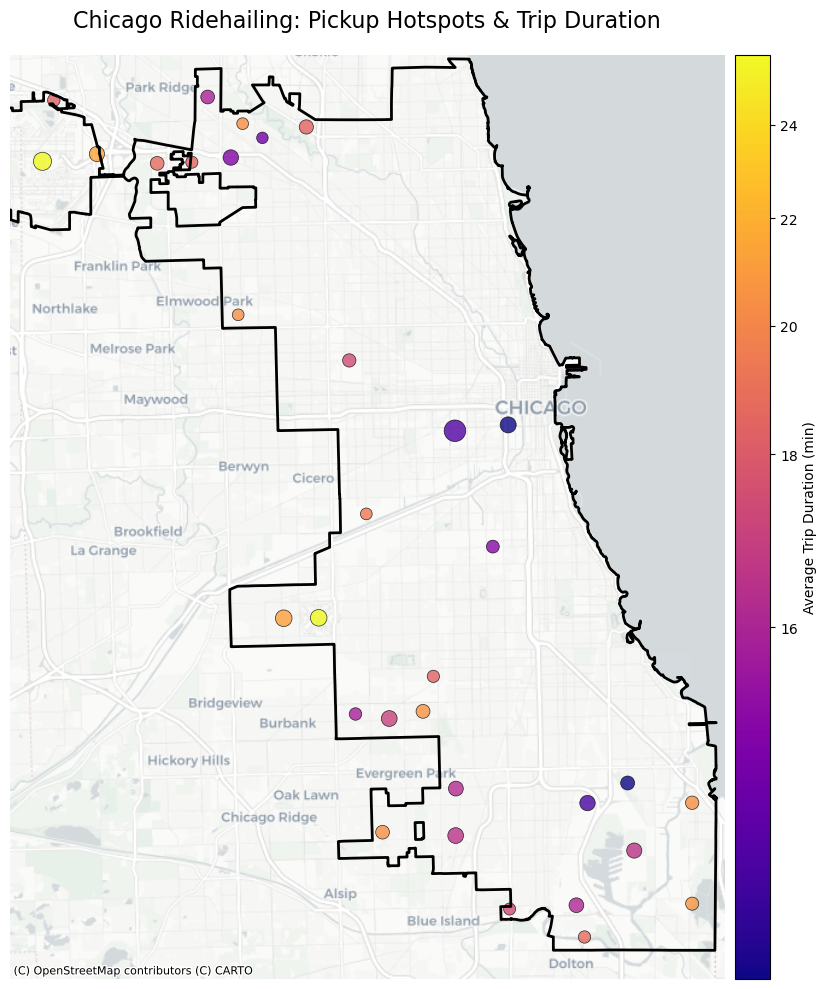

In [13]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import DBSCAN
import numpy as np
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable

# NOTE: If you receive a "ModuleNotFoundError: No module named 'contextily'" error,
# please install the package by running the following command in your terminal:
# pip install contextily

# --- File Paths (updated for parent directory) ---
# NOTE: If you receive a "No such file or directory" error, please verify the
# paths below point to the correct locations on your machine.
csv_path = '/Users/lenaigoumrane/DSML_Team_Assignment/Ridehailing_Chicago_sample327k.csv'
shapefile_path = '/Users/lenaigoumrane/DSML_Team_Assignment/3D_PLOT/datafiles/geo_export_50ab99d6-d6c7-45db-a4d8-04e55c03bdfc.shp'

# --- Data Loading and Preprocessing ---
# Load CSV with all data (no sampling)
# Note: This assumes the CSV file is located in the parent directory.
df = pd.read_csv(csv_path)

# Drop missing pickup locations to ensure valid geometry
df = df.dropna(subset=['pickup_centroid_location'])

# Convert WKT string to a geometry point object
df['geometry'] = df['pickup_centroid_location'].apply(wkt.loads)

# Create a GeoDataFrame from the DataFrame and set the CRS to WGS84 (EPSG:4326)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Calculate trip duration in minutes for the color metric
gdf['trip_duration_min'] = gdf['trip_seconds'] / 60

# --- DBSCAN Clustering (using a metric CRS) ---
# Project the data to a local metric CRS (EPSG:26971) for accurate distance-based clustering
gdf_proj = gdf.to_crs(epsg=26971)

# Extract coordinates from the projected data
coords = np.array(list(zip(gdf_proj.geometry.x, gdf_proj.geometry.y)))

# Run DBSCAN clustering with a 1km radius (eps=1000) and a minimum of 30 samples
dbscan = DBSCAN(eps=1000, min_samples=30)
clusters = dbscan.fit_predict(coords)
gdf_proj['cluster'] = clusters

# Filter out noise points (which have a cluster value of -1)
clustered = gdf_proj[gdf_proj['cluster'] != -1]

# Calculate key statistics for each cluster
cluster_stats = clustered.groupby('cluster').agg({
    'geometry': lambda x: x.geometry.values.union_all().centroid,  # Find the centroid of all points in the cluster
    'trip_duration_min': 'mean',  # Calculate the average trip duration
    'cluster': 'count'  # Count the number of points in the cluster
}).rename(columns={'cluster': 'size'})

# Create a new GeoDataFrame for the cluster centroids and their statistics
cluster_gdf = gpd.GeoDataFrame(cluster_stats, geometry='geometry', crs=gdf_proj.crs)

# --- Visual Enhancements ---
# Re-project the cluster centroids to Web Mercator (EPSG:3857) for the basemap
cluster_gdf = cluster_gdf.to_crs(epsg=3857)

# Scale marker size based on the number of points in the cluster (log scale for clarity)
# The markersize is clipped to avoid excessively large circles
cluster_gdf['marker_size'] = (np.log(cluster_gdf['size'] + 1) * 20).clip(upper=1000)

# Load Chicago community areas shapefile and re-project it for the boundary
community_areas = gpd.read_file(shapefile_path)
city_boundary = community_areas.to_crs(epsg=3857).unary_union

# --- Plotting ---
# Set up the plot figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Define the color scale limits for the colorbar using quantiles to handle outliers
vmin = cluster_gdf['trip_duration_min'].quantile(0.05)
vmax = cluster_gdf['trip_duration_min'].quantile(0.95)
# Use a PowerNorm for a better visual representation of the data distribution
norm = colors.PowerNorm(gamma=0.5, vmin=vmin, vmax=vmax)

# Plot the cluster centroids as circles, colored by average trip duration
# The colormap has been changed to 'plasma' for a more vibrant look
cluster_gdf.plot(
    ax=ax,
    marker='o',  # Use circles for the markers
    column='trip_duration_min',
    cmap='plasma',  # This is the new, cooler color scheme!
    norm=norm,
    markersize=cluster_gdf['marker_size'],
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5,
    legend=False,  # We will add a manual colorbar later
)

# Add a basemap from CartoDB to provide geographical context
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Plot the city boundary outline on top of the basemap and clusters
gpd.GeoSeries([city_boundary]).boundary.plot(ax=ax, edgecolor='black', linewidth=2, zorder=10)

# Customize the plot appearance
ax.set_title('Chicago Ridehailing: Pickup Hotspots & Trip Duration', fontsize=16, pad=20)
ax.axis('off')  # Turn off the axis labels and ticks

# Create and add a custom colorbar with a title
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([]) # A necessary workaround for some versions of matplotlib
fig.colorbar(sm, cax=cax, label='Average Trip Duration (min)')

# Display the final plot
plt.show()


---

## What line/s were changed exactly to get the colormap 'plasma'?

I made two changes to the code to use the `'plasma'` colormap.

The main change was on this line within the `cluster_gdf.plot()` function:

```python
    cmap='plasma',  # This is the new, cooler color scheme!
```

This line directly controls the color scheme of the scatter plot markers. The original code used `cmap='viridis'`.

I also updated the colormap for the colorbar to match the plot:

```python
    sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
```

By changing these two lines from `'viridis'` to `'plasma'`, the entire color scheme of the visualization was updated.